# Train a single ML model for all resolutions with first order gradients

In [1]:
import xarray as xr
import numpy as np 

import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
#from flax.core import freeze, unfreeze
from flax import linen as nn
from flax.training import train_state 
from flax.training import checkpoints
import flax
flax.config.update('flax_use_orbax_checkpointing', True)

import optax
import xbatcher
import fsspec

#import hvplot.xarray

import matplotlib.pyplot as plt
from datatree import DataTree
from datatree import open_datatree

from datetime import datetime

import xgcm

import sys

sys.path.append('../modules/')
import helper_func as hf
import ml_helper_func as ml_hf

In [2]:
import os 
M2LINES_BUCKET ='gs://leap-persistent/dhruvbalwada/m2lines_transfer'

# Open all the datasets
Lkey = ['50', '100', '200', '400']

res_name = 'all'

ds = {}
for L in Lkey:
    
    ds_temp = xr.open_zarr(f'{M2LINES_BUCKET}/ML_data/ds_ML_'+L+'km_3D')
    
    ds[L] = ds_temp
ds_tree = DataTree.from_dict(ds)

# Open the mask files
ds_mask_tree = open_datatree(f'{M2LINES_BUCKET}/ML_data/ds_ML_masks', engine='zarr')

In [4]:
output_channels = ['Sfnx','Sfny']                                      

input_channels = ['U_x', 'U_y', 
                  'V_x', 'V_y', 
                  'Sx', 'Sy', 'Lfilt']

In [5]:
design_name = 'first_order'

In [6]:
# Normalize by T_z for some variables
# Center all the data
facs = {}

ds_tree_centered = {}
ds_tree_centered_small = {}

for L in Lkey:
    
    # Select dataset
    ds = ds_tree[L].ds
    grid = xgcm.Grid(ds, periodic='X')
    
    ds_mask= ds_mask_tree[L].to_dataset().maskC
    
    # Center the variables
    ds_centered = hf.center_data(ds)
    ds_centered['T_z'] = (ds_centered['T_z'].where(ds_centered['T_z']>=5e-5, 5e-5)) #.isel(time=0, XC=0).plot(vmin=-6e-3)

    # Add variables that are actually used in the ML model.
    ds_centered['Sx'] = -ds_centered['T_x']/ds_centered['T_z']
    ds_centered['Sy'] = -ds_centered['T_y']/ds_centered['T_z']

    ds_centered['Sfnx'] =  - ds_centered['uT']/ds_centered['T_z']
    ds_centered['Sfny'] =  - ds_centered['vT']/ds_centered['T_z']
    
    ds_centered['Lfilt'] = (float(L) + 0*ds_centered.T)

    ds_ML_vars = xr.merge([ds_centered[output_channels], ds_centered[input_channels]])
    
    
    ds_tree_centered[L] = ds_ML_vars
    
        
    sub_samp_fac = int( 400/ int(L) )
    ds_ML_vars = ds_ML_vars.where(ds_mask>0.9999999, drop=True
                                 ).sel(Z=slice(-200, -2700), YC=slice(400e3,1600e3))
    
    ds_tree_centered_small[L] = ds_ML_vars.isel( XC=slice(0,None,sub_samp_fac), 
                                                YC=slice(0,None,sub_samp_fac) )
    
    
ds_tree_centered = DataTree.from_dict(ds_tree_centered)
ds_tree_centered_small = DataTree.from_dict(ds_tree_centered_small)

In [8]:
# Open standardization constants file (divide by std) 

# ds_std_tree = {}
# for L in Lkey:
#     #print(L)
#     ds = ds_tree_centered[L].to_dataset()

#     ds_var = list(ds.keys())
    
#     ds_mask = ds_mask_tree[L].to_dataset().maskC
    
#     try: 
#         ds_std = xr.open_zarr('./STD_'+L+'_km.nc')
#         print('Found '+L+'km standard deviations on local')
#     except:
#         print('Not found')
#         ds_std = hf.compute_std(ds, ds_mask, slice(0,100))
#         ds_std.compute();
#         ds_std.to_zarr('./STD_'+L+'_km.nc')
    
#     #ds_normalized = hf.normalize_ds(ds, ds_std)

#     ds_std_tree[L] = ds_std
    
# ds_std_tree = DataTree.from_dict(ds_std_tree)

- Mask the test and train data appropriately
- Split into test and train
- Add variable for filter scale
- Stack and merge into one. 
- batch 
- >> train

In [9]:
#%%time
#ds_tree_centered_small.load();

In [10]:
ds_train, ds_test = hf.split_train_test(ds_tree_centered_small)

In [11]:
ds_train_stacked = ds_train.stack(points=('XC','YC','Z','time'))
ds_test_stacked  = ds_test.stack(points=('XC','YC','Z','time'))

In [12]:
ds_test_concat = xr.concat([ds_test_stacked['50'].to_dataset(),
                            ds_test_stacked['100'].to_dataset(),
                            ds_test_stacked['200'].to_dataset(),
                            ds_test_stacked['400'].to_dataset()], 
                           dim='points')

ds_train_concat = xr.concat([ds_train_stacked['50'].to_dataset(),
                            ds_train_stacked['100'].to_dataset(),
                            ds_train_stacked['200'].to_dataset(),
                            ds_train_stacked['400'].to_dataset()],
                           dim='points')

In [13]:
ds_train_nonan = ds_train_concat.dropna('points', subset=['Sfnx'])
ds_test_nonan  = ds_test_concat.dropna('points', subset=['Sfnx'])

In [14]:
npoints_train = len(ds_train_nonan['Sfnx'])
npoints_test = len(ds_test_nonan['Sfnx'])
print(npoints_train, npoints_test)

11101500 1665225


In [15]:
%%time

ds_train_nonan.load();
ds_test_nonan.load();

CPU times: user 3min 4s, sys: 23.3 s, total: 3min 27s
Wall time: 3min 48s


In [16]:
ds_train_randomized = ds_train_nonan.isel(points=np.random.choice(npoints_train, size=npoints_train, replace=False))
ds_test_randomized  = ds_test_nonan.isel(points=np.random.choice(npoints_test, size=npoints_test, replace=False))

In [17]:
try: 
    ds_norms = xr.open_zarr('./STD_all.nc')
    print('Found all km standard deviations on local')
except:
    print('Not found')
    ds_norms = ds_train_randomized.std()
    ds_norms.compute();
    ds_norms.to_zarr('./STD_all.nc')

Found all km standard deviations on local


In [18]:
ds_train_normalized = (ds_train_randomized / ds_norms)
ds_test_normalized = (ds_test_randomized / ds_norms)

In [19]:
bgen_train = xbatcher.BatchGenerator(ds = ds_train_normalized, 
                               input_dims={},
                               batch_dims={'points': int(756000/2)}   )

bgen_test = xbatcher.BatchGenerator(ds = ds_test_normalized, 
                               input_dims={},
                               batch_dims={'points': int(756000/2)}   )

In [20]:
len(bgen_train), len(bgen_test)

(29, 4)

### ML model

In [21]:
# this is something we play with (I think 32, 24, 2 work quite well).

#size_name = 'small'
#layer_sizes = [24, 24, 2]

#size_name = 'medium'
#layer_sizes = [32, 32, 2]

size_name = 'large'
layer_sizes = [64, 64, 2]


model, params = ml_hf.initialize_model(layer_sizes, len(input_channels) )
#model, params = ml_hf.initialize_model([64, 32, 32, 2], len(input_channels), bias=False )

In [22]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(param_count)

4802


In [23]:
# setup loss function
loss_grad_fn = jax.value_and_grad(ml_hf.mse) # more convenient function as it outputs both value and gradient.

In [24]:
# Setup optimizer 

learning_rate = .01 # .05 for 100, .01 for 100, .05 for 100
# Maybe useful if wanting to set learning rates manually: https://github.com/deepmind/optax/issues/4

# Initialize optimizer
tx = optax.adam(learning_rate=learning_rate)

# Define training state 
state = train_state.TrainState.create(
            apply_fn=model.apply, params=params, tx=tx)

In [25]:
num_epochs = 201

In [26]:
# initialize for wandb
import wandb
wandb.login()

wandb: Currently logged in as: dhruvbalwada (m2lines). Use `wandb login --relogin` to force relogin


True

In [27]:
run = wandb.init(
    # Set the project where this run will be logged
    project="pointwise_oct_2023",
    # Track hyperparameters and run metadata
    name=design_name + ", "+ res_name + ", " + size_name,
    config={
        "scale": Lkey,
        "learning_rate": learning_rate,
        "epochs": num_epochs,
        "layer_sizes": layer_sizes,
        "inputs": input_channels, 
        "outputs": output_channels,
        "date": str(datetime.now()),
    })

In [28]:
# to track model
train_loss = np.array([])
test_loss = np.array([])

In [29]:
%%time
# Main training loop


for i in range(num_epochs):
    n=0
    
    loss_temp = np.array([]) # temp array to save batches
    for batch in bgen_train:
        
        #batch = ml_hf.zero_nans(batch, 'uTbyT_z')
        X_train = jnp.asarray(batch[input_channels].to_array().transpose(...,'variable').data)
        y_train = jnp.asarray(batch[output_channels].to_array().transpose(...,'variable').data)
        
        
        # Compute gradients and update parameters and optimizer state 
        loss_val, grads = loss_grad_fn(state.params, state.apply_fn, X_train, y_train)
        state = state.apply_gradients(grads=grads)
        
        loss_temp = np.append(loss_temp, loss_val)
    
    
    train_loss = np.append(train_loss, np.mean(loss_temp))
    
    test_loss_temp = np.array([])
    for batch in bgen_test:
        
        #batch = ml_hf.zero_nans(batch, 'uTbyT_z')
        X_test = jnp.asarray(batch[input_channels].to_array().transpose(...,'variable').data)
        y_test = jnp.asarray(batch[output_channels].to_array().transpose(...,'variable').data)
        
        test_loss_temp = np.append(test_loss_temp, ml_hf.mse(state.params, state.apply_fn, X_test, y_test))
    
    test_loss = np.append(test_loss, np.mean(test_loss_temp))
    
    wandb.log({'train_loss': train_loss[-1], 'test_loss': test_loss[-1]})
    
    if i % 10  == 0:
        print(f'Train loss step {i}: ', train_loss[-1], f'test loss:', test_loss[-1])
        

Train loss step 0:  0.7106225593336697 test loss: 0.5556425899267197
Train loss step 10:  0.17439571125753994 test loss: 0.18136179074645042
Train loss step 20:  0.1638326449640866 test loss: 0.1714000105857849
Train loss step 30:  0.16086095211834744 test loss: 0.1683257296681404
Train loss step 40:  0.15803210745597707 test loss: 0.16596711426973343
Train loss step 50:  0.15657664321619888 test loss: 0.16425712779164314
Train loss step 60:  0.15483580015856643 test loss: 0.16280179470777512
Train loss step 70:  0.1538816443805037 test loss: 0.16113541275262833
Train loss step 80:  0.1527994603946291 test loss: 0.160322405397892
Train loss step 90:  0.15190303788102907 test loss: 0.1594306156039238
Train loss step 100:  0.15098673053856554 test loss: 0.15842515602707863
Train loss step 110:  0.15026724698214694 test loss: 0.15844879671931267
Train loss step 120:  0.14939193119262828 test loss: 0.15732363983988762
Train loss step 130:  0.14889211747153053 test loss: 0.15692012012004852

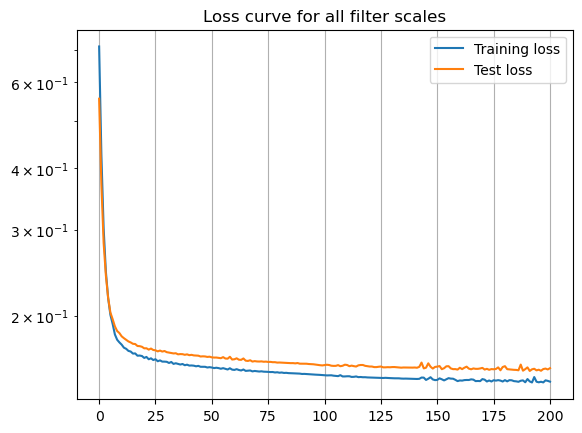

In [30]:
fig, ax = plt.subplots()

ax.plot(train_loss, label='Training loss')
ax.plot(test_loss, label='Test loss')

ax.set_title('Loss curve for all filter scales')
ax.grid()
ax.set_yscale('log')
ax.legend()

fig.savefig('figures/'+res_name+'_km'+'/loss_curve_'+size_name+'.png')

run.log({"loss_curve": wandb.Image(fig)})

In [31]:
# Save the checkpoint
CKPT_DIR = 'ckpts_single_all_res_'+size_name
checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=1, overwrite=True)

'ckpts_single_all_res_large/checkpoint_1'

In [32]:
# Read back from the checkpoint
state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)

In [33]:
input_norms = np.zeros((len(input_channels),))

for n, i in enumerate(input_channels):
    #print(i + '=' + str(ds_std[i].values))
    input_norms[n] = ds_norms[i].values
    
output_norms = np.zeros((len(output_channels),))

for n, i in enumerate(output_channels):
    #print(i + '=' + str(ds_std[i].values))
    output_norms[n] = ds_norms[i].values
    
ds_layers = xr.Dataset()

ds_layers['layer_sizes'] = xr.DataArray(np.array([len(input_channels),layer_sizes[0], layer_sizes[1], len(output_channels)]).astype('int32'), dims=['num_layers'])

ds_layers['A0'] = xr.DataArray(np.array(state.params['params']['layers_0']['kernel']).astype('float32'), dims=['input', 'layer1'])
ds_layers['b0'] = xr.DataArray(np.array(state.params['params']['layers_0']['bias']).astype('float32'), dims=['layer1'])

ds_layers['A1'] = xr.DataArray(np.array(state.params['params']['layers_1']['kernel']).astype('float32'), dims=['layer1', 'layer2'])
ds_layers['b1'] = xr.DataArray(np.array(state.params['params']['layers_1']['bias']).astype('float32'), dims=['layer2'])

ds_layers['A2'] = xr.DataArray(np.array(state.params['params']['layers_2']['kernel']).astype('float32'), dims=['layer2', 'output'])
ds_layers['b2'] = xr.DataArray(np.array(state.params['params']['layers_2']['bias']).astype('float32'), dims=['output'])

ds_layers['input_norms'] = xr.DataArray(input_norms.astype('float32'), dims=['input'])
ds_layers['output_norms'] = xr.DataArray(output_norms.astype('float32'), dims=['output'])

In [34]:
ds_layers['layer_sizes'] 

<xarray.DataArray 'layer_sizes' (num_layers: 4)>
array([ 7, 64, 64,  2], dtype=int32)
Dimensions without coordinates: num_layers

In [35]:
ds_layers.to_netcdf('ann_params_all_res_'+size_name+'.nc', mode='w')

### Check if the model is doing well. 

In [41]:
def R2_score(true, pred, dims = ['XC', 'YC', 'Z', 'time']):
    RSS = ((true  - pred)**2).mean(dims)
    TSS = ((true)**2).mean(dims)
    R2 = 1 - RSS/TSS
    return R2 

def corr(true, pred, dims=['XC', 'YC', 'time','Z']):
    RSS = ((true - true.mean(dims))* (pred - pred.mean(dims))).mean(dims)
    TSS1 = ((true - true.mean(dims))**2).mean(dims)
    TSS2 = ((pred - pred.mean(dims))**2).mean(dims)
   
    corr =  RSS/(TSS1**0.5 * TSS2**0.5)
    return corr

In [42]:
R2_all = np.zeros((4,2))
corr_all = np.zeros((4,2))

for i, L in enumerate(Lkey):
    ds_mask = ds_mask_tree[L].ds.maskC
    ds_test = ds_tree_centered[L].ds.isel(time=slice(-10,-1)).where(ds_mask>0.99999).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))

    ds_test_normalized = ds_test/ds_norms

    y_pred = state.apply_fn(state.params, 
                            ds_test_normalized[input_channels].to_array().transpose(...,'variable'))

    dims = ds_test[output_channels].to_array().transpose(...,'variable').dims
    coords = ds_test[output_channels].to_array().transpose(...,'variable').coords

    ds_pred = xr.DataArray(y_pred, dims=dims, coords=coords).to_dataset(dim='variable')
    
    R2_all[i,0] = R2_score(ds_test_normalized, ds_pred).Sfnx.values
    R2_all[i,1] = R2_score(ds_test_normalized, ds_pred).Sfny.values
    
    corr_all[i,0] = corr(ds_test_normalized, ds_pred).Sfnx.values
    corr_all[i,1] = corr(ds_test_normalized, ds_pred).Sfny.values

In [43]:
R2_all

array([[0.96040315, 0.96752425],
       [0.92948297, 0.94518822],
       [0.87050913, 0.89708722],
       [0.8149873 , 0.78633321]])

In [44]:
corr_all

array([[0.98003839, 0.98366683],
       [0.96413229, 0.97170071],
       [0.93276058, 0.94395916],
       [0.89954609, 0.8703123 ]])

/tmp/ipykernel_1081/3345578052.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


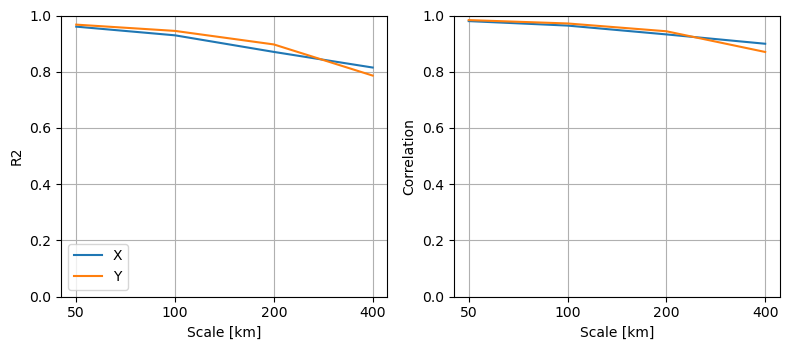

In [45]:
fig = plt.figure(figsize=(8 , 3.6))

plt.subplot(121)
plt.plot(Lkey, R2_all, label=['X', 'Y'])
plt.ylim([0., 1.])
plt.xlabel('Scale [km]')
plt.ylabel('R2')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(Lkey, corr_all)
plt.ylim([0., 1.])
plt.tight_layout()
plt.xlabel('Scale [km]')
plt.ylabel('Correlation')
plt.grid()

plt.tight_layout()
run.log({"R2&Corr": wandb.Image(fig)})

In [46]:
run.finish()

test_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,0.1546
train_loss,0.14717
